In [ ]:
# Let's load some other packages we need
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time
%matplotlib inline
import nibabel as nib # common way of importing nibabel
import h5py
from moviepy.editor import VideoFileClip
import glob

In [ ]:
'data/algonauts_2025.competitors/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5'
root_data_dir = './data/algonauts_2025.competitors'
initial_dir = os.getcwd() 

In [24]:
# Open the fMRI responses file, and extract the specific dataset 
fmri_file_path = root_data_dir + "/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
name_session = "s01e09b"
# Open the H5 file in read mode
def get_fmri_data(fmri_file_path, name_session):
    with h5py.File(fmri_file_path, 'r') as file:
        #print(f"Keys: {list(file.keys())}")
        a_group_key = list(file.keys())
        for i in a_group_key:  
            if name_session in i:
                print("Found: ", i)
                dataset_name = i
                break
        fmri_data = file[dataset_name][()]
    return fmri_data

# Load the fMRI data
fmri_data = get_fmri_data(fmri_file_path, "s01e09b")

Found:  ses-004_task-s01e09b


In [28]:
def get_ep_path():
    os.chdir("../algonauts_2025.competitors")
    documents_path = os.getcwd() +"/stimuli/movies/friends/s1"
    paths=[glob.glob(os.path.join(documents_path, "*.mkv"))]
    return paths

In [29]:
episode_paths = get_ep_path()
for i in episode_paths[0]:
    if name_session in i:
        episode_path =i
        break
print("Episode path: ", episode_path)
start_time = 0.0
tr=1.45
clip = VideoFileClip(episode_path)
start_times = [x for x in np.arange(0, clip.duration, tr)][:-1]


Episode path:  /Users/genevievelam/Documents/GitHub/algonauts_2025.competitors/stimuli/movies/friends/s1/friends_s01e09b.mkv


In [40]:
events = pd.DataFrame(data={'onset': start_times, 'duration': [tr]*len(start_times), 'trial_type': ['movie']*len(start_times)})
events.head()

,onset,duration,trial_type
0,0.00,1.45,movie
1,1.45,1.45,movie
2,2.90,1.45,movie
3,4.35,1.45,movie
4,5.80,1.45,movie


In [ ]:
start_times = [x for x in np.arange(0, clip.duration, tr)][:-1]

In [44]:
clip.duration

696.17

# Functional Connectivity

In [51]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([fmri_data])[0]

In [60]:
from nilearn import datasets
msdl_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=1000,data_dir=initial_dir+'/data/')

[get_dataset_dir] Dataset found in /Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/schaefer_2018
[fetch_single_file] Downloading data from https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_1000Parcels_7Networks_order.txt ...
[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz ...
[fetch_single_file]  ...done. (0 seconds, 0 min)



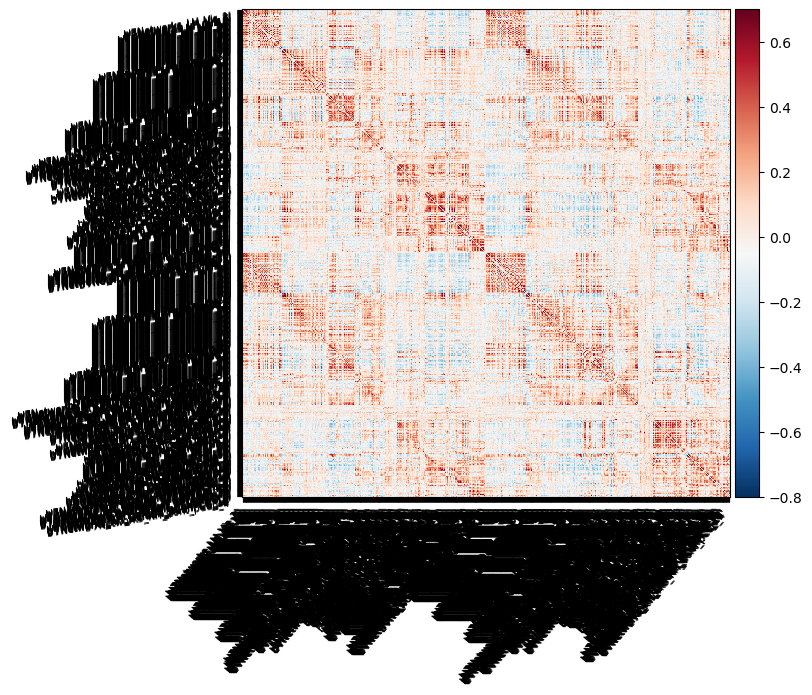

In [ ]:
from nilearn import plotting
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=msdl_atlas.labels,figure=(20, 15),
                     vmax=0.7, vmin=-0.8, colorbar=True)

In [ ]:
from nilearn import plotting
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=msdl_atlas.labels,figure=(20, 15),
                     vmax=0.7, vmin=-0.8, colorbar=True)

As shown in heat plot, the confounds has been removed. Below would be how a correlations graph will look like if confounds aren't removed
The image is taken from [nilearn](https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py)


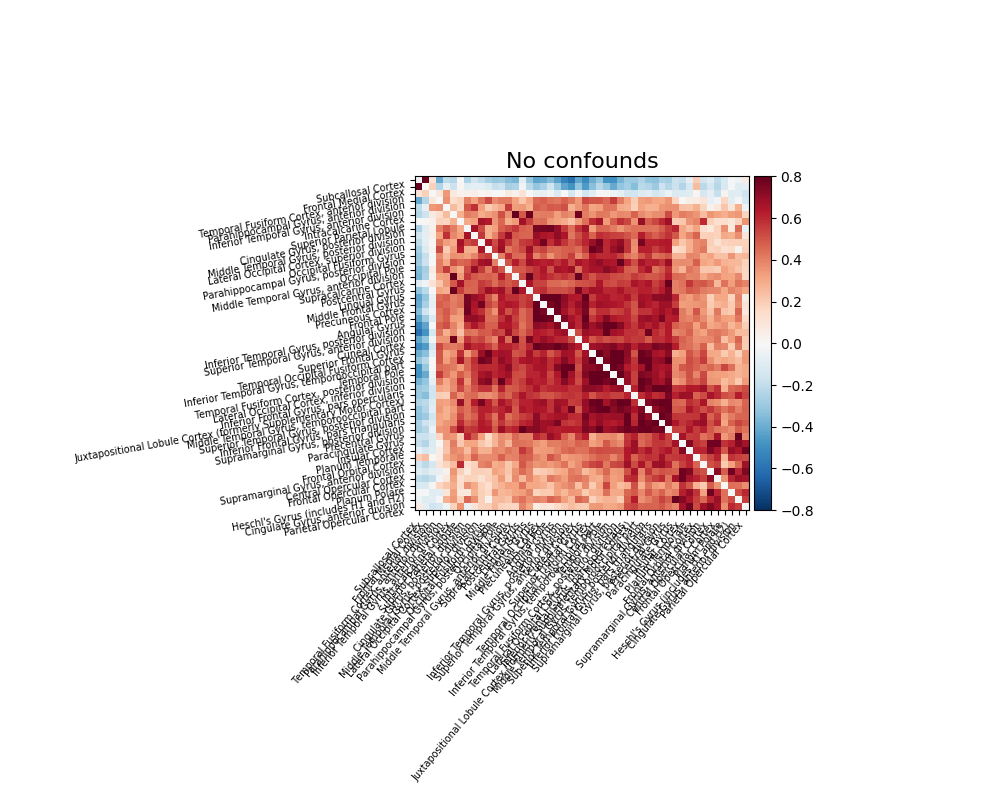

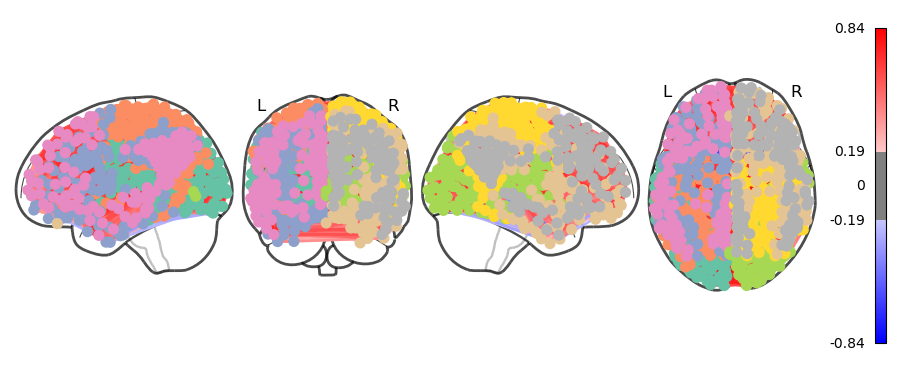

In [78]:
# Compute node coordinates from the atlas
from nilearn.plotting import find_parcellation_cut_coords

node_coords = find_parcellation_cut_coords(labels_img=msdl_atlas.maps)
plotting.plot_connectome(correlation_matrix, node_coords, colorbar=True, edge_threshold="80%", display_mode="lyrz")
plotting.show()

In [ ]:
fmri_file_path = root_data_dir + "/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"

# Model Connectivity 

In [80]:
from voxelwise_tutorials.utils import explainable_variance

ev = explainable_variance(fmri_data)
print("(n_voxels,) =", ev.shape)

(n_voxels,) = ()


In [87]:
fmri_data.shape

(468, 1000)

IndexError: invalid index to scalar variable.

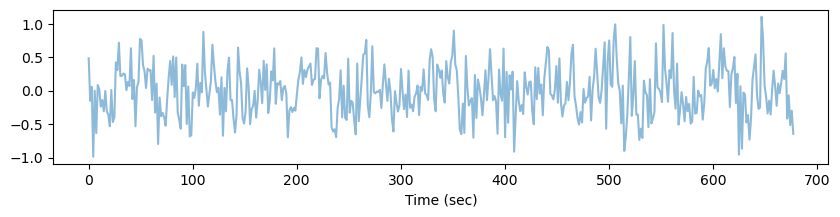

In [88]:

voxel_1 = np.argmax(ev)
time = np.arange(fmri_data.shape[0]) * 1.45  # one time point every 1.45 seconds
plt.figure(figsize=(10, 2))
plt.plot(time, fmri_data[:,  voxel_1].T, color='C0', alpha=0.5)
#plt.plot(time, fmri_data[:,  voxel_1].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with large explainable variance (%.2f)" % ev[voxel_1])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()